In [ ]:
pip install flair

     |████████████████████████████████| 337kB 9.9MB/s 
     |████████████████████████████████| 983kB 14.5MB/s 
     |████████████████████████████████| 798kB 34.4MB/s 
     |████████████████████████████████| 1.1MB 45.0MB/s 
     |████████████████████████████████| 71kB 10.3MB/s 
     |████████████████████████████████| 19.7MB 1.1MB/s 
     |████████████████████████████████| 1.3MB 51.9MB/s 
     |████████████████████████████████| 2.9MB 47.7MB/s 
     |████████████████████████████████| 890kB 49.5MB/s 
  Created wheel for sqlitedict: filename=sqlitedict-1.7.0-cp36-none-any.whl size=14377 sha256=07342fb167cd63aae66a1d76e10d8c0fd72001f87237165c8d7a880bf1738230
  Stored in directory: /root/.cache/pip/wheels/cf/c6/4f/2c64a43f041415eb8b8740bd80e15e92f0d46c5e464d8e4b9b
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993195 sha256=3ae20830696e69f254100aa2891e493894f8e3dae307f24fb95aa01427de55e7
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from flair.models import TextClassifier
from flair.data import Sentence

In [ ]:
import pandas as pd

#### Prepare data to put in the model

In [ ]:
data = pd.read_csv('/content/drive/My Drive/IS424/news_processed.csv', encoding='latin-1').sample(frac=1).drop_duplicates()

In [ ]:
data = data[['target', 'text_aft']].rename(columns={"target":"label", "text_aft":"text"})

In [ ]:
data['label'] = '__label__' + data['label'].astype(str)

In [ ]:
# split data to train, test, dev dataset
data.iloc[0:int(len(data)*0.8)].to_csv('train.csv', sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.8):int(len(data)*0.9)].to_csv('test.csv', sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.9):].to_csv('dev.csv', sep='\t', index = False, header = False);

In [ ]:
from flair.data_fetcher import NLPTaskDataFetcher
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentLSTMEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from pathlib import Path
from flair.data import Corpus
from flair.datasets import ClassificationCorpus

In [ ]:
#loads all datasets into a corpus object.

corpus = ClassificationCorpus(Path('./'), test_file='test.csv', dev_file='dev.csv', train_file='train.csv')


2020-11-13 10:13:11,455 Reading data from .
2020-11-13 10:13:11,456 Train: train.csv
2020-11-13 10:13:11,457 Dev: dev.csv
2020-11-13 10:13:11,458 Test: test.csv


##### Create Word Embedding

In [ ]:
#create a list of the embeddings (two Flair contextual sting embeddings and a GloVe word embedding) used as an input for document embedding object

word_embeddings = [WordEmbeddings('glove'), FlairEmbeddings('news-forward-fast'), FlairEmbeddings('news-backward-fast')]

In [ ]:
# put the word embeddings into LSTM Embedding layer

document_embeddings = DocumentLSTMEmbeddings(word_embeddings, hidden_size=512, reproject_words=True, reproject_words_dimension=128)

<ipython-input-12-347e62a4aff2>:1: DeprecationWarning: Call to deprecated method __init__. (The functionality of this class is moved to 'DocumentRNNEmbeddings') -- Deprecated since version 0.4.
  document_embeddings = DocumentLSTMEmbeddings(word_embeddings, hidden_size=512, reproject_words=True, reproject_words_dimension=128)


In [ ]:
# Create Classifier instance

classifier = TextClassifier(document_embeddings, label_dictionary=corpus.make_label_dictionary(), multi_label=False)

2020-11-04 23:30:44,353 Computing label dictionary. Progress:


100%|███████████████████████████████████████████████████████████████████████████| 39645/39645 [03:25<00:00, 192.87it/s]

2020-11-04 23:38:24,228 [b'0', b'1']


#### Train model

In [ ]:
#train model

trainer = ModelTrainer(classifier, corpus)

In [ ]:
trainer.train(Path('./'), max_epochs=10, mini_batch_size=16, num_workers=0, checkpoint=True)

2020-10-26 13:44:05,017 ----------------------------------------------------------------------------------------------------
2020-10-26 13:44:05,019 Model: "TextClassifier(
  (document_embeddings): DocumentLSTMEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): WordEmbeddings('glove')
      (list_embedding_1): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.25, inplace=False)
          (encoder): Embedding(275, 100)
          (rnn): LSTM(100, 1024)
          (decoder): Linear(in_features=1024, out_features=275, bias=True)
        )
      )
      (list_embedding_2): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.25, inplace=False)
          (encoder): Embedding(275, 100)
          (rnn): LSTM(100, 1024)
          (decoder): Linear(in_features=1024, out_features=275, bias=True)
        )
      )
    )
    (word_reprojection_map): Linear(in_features=2148, out_features=128, bias=True)
    (rnn): GRU(128, 512)
 

Continue training from saved checkpoint

In [ ]:
from pathlib import Path

checkpoint = 'checkpoint.pt'
trainer = ModelTrainer.load_checkpoint(checkpoint,corpus)
trainer.train(Path('./'),
              max_epochs=10,
              mini_batch_size=16, 
              num_workers=0,
              checkpoint=True)

2020-10-27 04:34:12,126 ----------------------------------------------------------------------------------------------------
2020-10-27 04:34:12,128 Model: "TextClassifier(
  (document_embeddings): DocumentLSTMEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): WordEmbeddings('glove')
      (list_embedding_1): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.25, inplace=False)
          (encoder): Embedding(275, 100)
          (rnn): LSTM(100, 1024)
          (decoder): Linear(in_features=1024, out_features=275, bias=True)
        )
      )
      (list_embedding_2): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.25, inplace=False)
          (encoder): Embedding(275, 100)
          (rnn): LSTM(100, 1024)
          (decoder): Linear(in_features=1024, out_features=275, bias=True)
        )
      )
    )
    (word_reprojection_map): Linear(in_features=2148, out_features=128, bias=True)
    (rnn): GRU(128, 512)
 

{'dev_loss_history': [0.007915562950074673,
  0.0071281325072050095,
  0.005925783887505531,
  0.007020766381174326,
  0.005784482229501009,
  0.005790039896965027],
 'dev_score_history': [0.9982, 0.9982, 0.9984, 0.9982, 0.9986, 0.9986],
 'test_score': 0.9982,
 'train_loss_history': [0.016112424498317818,
  0.009478498110439415,
  0.01745975571585234,
  0.007176098632526979,
  0.0054288300712837185,
  0.0043605043210136335]}

In [ ]:
from flair.models import TextClassifier
from flair.data import Sentence

In [ ]:
#load best model 

classifier = TextClassifier.load('/content/drive/My Drive/IS424/flair/best-model.pt')

2020-11-13 10:13:29,928 loading file /content/drive/My Drive/IS424/flair/best-model.pt


In [ ]:
result,_ = classifier.evaluate(corpus.test)

In [ ]:
print(result.detailed_results)


Results:
- F-score (micro) 0.9991
- F-score (macro) 0.9991
- Accuracy 0.9991

By class:
              precision    recall  f1-score   support

           1     0.9987    0.9996    0.9991      2290
           0     0.9995    0.9986    0.9991      2115

   micro avg     0.9991    0.9991    0.9991      4405
   macro avg     0.9991    0.9991    0.9991      4405
weighted avg     0.9991    0.9991    0.9991      4405
 samples avg     0.9991    0.9991    0.9991      4405



Test and predict

In [ ]:
# create example sentence

sentence = Sentence('many people raised alarm regarding fact donald trump dangerously close becoming autocrat thing democracy become autocracy right people nose often look like democracy beginning phase explained republican david frum couple month donald trump presidency piece atlantic called build autocracy fact really look critically happening right systematic discrediting vital institution free press federal bureau investigation well direct weaponization department justice order go trump former political opponent democratic nominee hillary clinton making autocracy well way one chamber congress house representative already rogue band republican running parallel investigation official russian collusion investigation explicit intent undermining discrediting idea trump could possibly done anything wrong russian order swing election starter trump making united nation ambassador nikki haley bully threaten country united nation voted trump decision change policy come recognition jerusalem capital jewish state well one expert usually quite measured enough trump autocratic antic former cia director john brennan seasoned spy took trump favorite platform twitter blasted decision trump admin threat retaliate nation exercise sovereign right un oppose u position jerusalem beyond outrageous show realdonaldtrump expects blind loyalty subservience everyone quality usually found narcissistic vengeful autocrat john brennan johnbrennan december brennan correct course trump behaving like autocrat many people nation asleep come dangerous age greatest threat democracy fabric republic american president fellow american know congress check trump supposed time get flip house possibly senate resist meantime want save country devolving something look like russia north korea america always know already well image via brendan image')

In [ ]:
# predict class and print

classifier.predict(sentence)
predict = sentence.labels
print(sentence.labels)

[1 (1.0)]


In [ ]:
#append only labels into list
predicted_text = []
for row in corpus.test:
  classifier.predict(row)
  label = row.labels
  predicted_text.append(int(label[1].value))

In [ ]:
#print test rows
print(predicted_text) 

[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 

In [ ]:
#remove 'predicted' labels
[row.remove_labels('predicted') for row in corpus.test]

#get labels for actual
true_values_for_batch = [int(row.get_labels()[0].value) for row in corpus.test]
print(true_values_for_batch)

[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score

In [ ]:
y_pred = predicted_text
y_true = true_values_for_batch

In [ ]:
accuracy_score(y_true, y_pred)

0.9990919409761635

In [ ]:
f1_score(y_true, y_pred)

0.9991270187690965

In [ ]:
recall_score(y_true, y_pred)

0.9995633187772925

In [ ]:
precision_score(y_true, y_pred)

0.9986910994764397

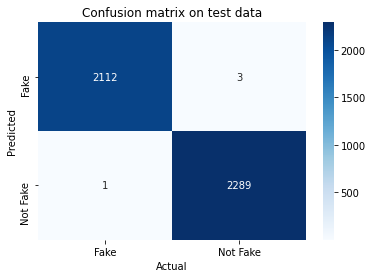

In [ ]:
#plot confusion matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(y_true,y_pred) , index = ['Fake','Not Fake'] , columns = ['Fake','Not Fake'])
sns.heatmap(cm,cmap= 'Blues', annot = True, fmt='', xticklabels = ['Fake','Not Fake'], yticklabels = ['Fake','Not Fake'])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Confusion matrix on test data')
plt.show()